# Compte rendu Titouan Mendiharat

In [1]:
# Imports

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import KFold
from numpy.linalg import inv
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy import stats
from scipy.stats import t
from sklearn.linear_model import ElasticNet
import seaborn as sns
import warnings


In [2]:
sns.reset_defaults()
sns.set(style='darkgrid', palette = 'colorblind')

### Question 1

#### a) Set the seed to 0

In [3]:
# Set the seed to 0
np.random.seed(0)

#### b) Load the data. Print the mean, and standard deviation of every covariate. Is the data centered? Normalized? Standardized?

In [4]:
# Load the data in a dataframe
data = pd.read_csv('meatspec.csv')

# Compute the mean and standard deviation
mean = data.mean()
std = data.std()

# Print the results
print('MEAN')
print(mean)
print (' ')
print('STANDARD DEVIATION')
print(std)

MEAN
V1       2.808561
V2       2.811137
V3       2.813727
V4       2.816363
V5       2.819098
          ...    
V97      3.081070
V98      3.062290
V99      3.043548
V100     3.024895
fat     18.142326
Length: 101, dtype: float64
 
STANDARD DEVIATION
V1       0.410793
V2       0.413352
V3       0.415906
V4       0.418465
V5       0.421040
          ...    
V97      0.539730
V98      0.538586
V99      0.537108
V100     0.535354
fat     12.740297
Length: 101, dtype: float64


We first printed the mean of every column then its standard deviation. Since the mean isn't equal to 0, the data isn't centered. Therefore is cannot be nomalized or standardized neither (plus the standard deviation isn't equal to 1).

#### c) Separate the data in train and test sets and standardize both of them

In [5]:
# Separate the data from the expected results
X = data.drop(data.columns[-1], axis=1)
y = data.iloc[:, -1]

# Divide X and y into train and test sets
Xbase_train, Xbase_test, ybase_train, ybase_test = train_test_split(X, y, test_size = 0.25, random_state=0)

# Standardize the sets
scaler = StandardScaler()
X_train = scaler.fit_transform(Xbase_train)
X_test = scaler.transform(Xbase_test)
y_train = scaler.fit_transform(np.array(ybase_train).reshape(-1,1)).flatten()
y_test = scaler.transform(np.array(ybase_test).reshape(-1,1)).flatten()

#### d) Fit a regular OLS, do we need to fit the intercept?

In [6]:
# Define the model
model = LinearRegression()

# Predict the results
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

No, we don't need to fit the intercept since our data is standardized.

#### e) Create a dataFrame df_coef and store the R2 coefficients of the estimated model

In [7]:
# Compute the r2 coefficients and put them in a dataframe
r2 = r2_score(y_test, y_pred)
df_coef = pd.DataFrame({'OLS': [r2]})

# Print the results
print("The R2 coefficient is : {}".format(r2))

The R2 coefficient is : 0.9600547777928068


## Variable selection

### Question 2

In [9]:
# Define a function to compute the p-values : we will use a test T
def p_value(X, y, n, p) :
    X=X.reshape(-1,1)
    lr = LinearRegression(fit_intercept=False)
    lr.fit(X,y)
    theta = lr.coef_
    s = 1/n * (X.T @ X)
    s_inv = np.linalg.inv(s)
    y_pred = lr.predict(X)
    sigma = 1/(n-2) * (np.linalg.norm(y-y_pred)**2)
    T = np.sqrt(n)*np.abs(theta)/(s_inv*sigma)
    p_value = 2*(1-t.cdf(T, n-p-1))
    return p_value

def forward_variable_selection(X,y):
    n = X.shape[0]
    p = X.shape[1]
    r = y
    pvals = []
    selected_vars = []
    A = list(range(p))
    # Iterate over range(p) to make sure to deal with every variable
    for i in range(p) :
        bestpval = 10
        # Select the variables that were not dealt with yet
        for j in A :
            pval = p_value(X[:,j], r, n, p)[0][0]
            if pval < bestpval :
                bestpval = pval
                bestvar = j
        pvals.append(bestpval)
        selected_vars.append(bestvar)
        A.remove(bestvar)
        lr = LinearRegression(fit_intercept=False)
        lr.fit(X[:, bestvar].reshape(-1,1), r)
        y_pred = lr.predict(X[:, bestvar].reshape(-1,1))
        r = r - y_pred
    return pvals, selected_vars

pvals, features = forward_variable_selection(X_train, y_train)

print(features)
print(pvals)
    

[40, 7, 39, 6, 41, 8, 38, 5, 42, 9, 37, 4, 36, 10, 97, 3, 43, 11, 35, 2, 96, 12, 98, 13, 34, 1, 44, 0, 95, 14, 33, 15, 99, 16, 32, 17, 94, 18, 93, 19, 45, 64, 31, 65, 92, 63, 91, 66, 90, 67, 30, 20, 89, 62, 88, 68, 46, 61, 87, 69, 86, 60, 85, 53, 29, 52, 84, 70, 83, 54, 28, 59, 82, 21, 47, 55, 81, 58, 27, 51, 80, 71, 26, 56, 79, 57, 48, 72, 78, 50, 25, 22, 77, 73, 24, 74, 76, 75, 49, 23]
[8.215650382226158e-15, 0.02082905738668339, 0.02065632626606395, 0.01968344635480279, 0.0203679059564561, 0.019602206734373073, 0.0204806368504149, 0.01976466576605662, 0.02386510588665125, 0.02329364570614878, 0.023193373244933646, 0.02281261394388645, 0.030176737718904834, 0.02951220198796034, 0.03338122069829663, 0.037672203111861924, 0.0347599753703518, 0.034169208076720636, 0.03840943774444594, 0.039607509306966326, 0.04377752524085721, 0.0475645542714942, 0.05208141917750564, 0.06063164962214529, 0.05593828156454883, 0.05561124286793406, 0.06833730520847237, 0.07238025952410632, 0.07647607298416

### Question 3

 #### a) Apply the OLS

In [10]:
# Select the variables whose p_value is < 0.05
selected_var = []
selected_indexes = []
for i in range(len(features)) :
    if pvals[i] < 0.05 :
        selected_var.append("V{}".format(features[i]))
        selected_indexes.append(features[i])

# Apply the OLS to the selected set
X_selected = X[selected_var]
model.fit(X_selected, y)
model.predict(X_selected)

# Print the results
print("The coefficients of the model are {}.".format(model.coef_))


The coefficients of the model are [ 59233.12114515 -27540.50468385 -25637.25225839  37597.02996794
 -74189.42157703  22634.26577694   8448.73239003 -45669.33475007
  46952.83227049  -8320.1266037   -4927.90914278  25308.10793762
   6972.50691421  -2001.29909442   -122.98368206   1700.88512346
 -12133.2037682   13079.81008287  -4710.46849607  -5828.4135057
    111.93951273 -10959.33652463].


#### b) Store the R2 coefficient in df_coef

In [11]:
# Store the r2 coefficient in df_coef
df_coef['OLS with variable selection'] = model.score(X_selected, y)

# Print it
print("Its R2 coefficient is : {}".format(model.score(X_selected, y)))
print(' ')
print(df_coef)

Its R2 coefficient is : 0.9601005203234244
 
        OLS  OLS with variable selection
0  0.960055                     0.960101


### Question 4

In [12]:
# Define the sls
reg = LinearRegression().fit(X_train, y_train)
sfs = SequentialFeatureSelector(reg, n_features_to_select=len(selected_var))
sfs.fit(X_train,y_train)

# Print the results to be able to compare with the previous ones
print(sfs.get_support(indices=True)) #gives index from selected optimal features
print(np.sort(selected_var)) 

[ 0  1  3  7 18 19 21 34 39 40 44 45 46 47 48 49 57 74 87 90 97 99]
['V10' 'V11' 'V12' 'V2' 'V3' 'V35' 'V36' 'V37' 'V38' 'V39' 'V4' 'V40'
 'V41' 'V42' 'V43' 'V5' 'V6' 'V7' 'V8' 'V9' 'V96' 'V97']


As we saw, the 2 algorithms do not return the same variables in the same order. Hence, it is safe to assume that they do not work the same way. Maybe the sfs from sklearn could be less precise for computional issues on bigger problems.

In [13]:
# Define a function to compute R2 coefficients
def r2coeff_np(y, y_pred) :
    mean = y.mean()
    sum1 = 0
    sum2 = 0
    for i in range(len(y)-1) :
        sum1 = sum1 + (y[i]-y_pred[i])**2
        sum2 = sum2 +(y[i]-mean)**2
    r2 = 1-(sum1/sum2)
    return r2

In [16]:
# Test and train data with selected variables of method 2
m = len(sfs.get_support(indices=True))
n1 = len(X_train)
n2 = len(X_test)
X_train_selected_2 = np.zeros((n1, m))
X_test_selected_2 = np.zeros((n2, m))

for j, row in enumerate(selected_indexes):
    X_train_selected_2[:, j] = X_train[:, row]
    X_test_selected_2[:, j] = X_test[:, row]

# OLS regression on X with selected variablesof method 2
reg_method_2 = LinearRegression().fit(X_train_selected_2, y_train)
y_pred = reg_method_2.predict(X_test_selected_2)

#store R2 in the data frame 
df_coef['SFS'] = r2coeff_np(y_pred, y_test)

# Print it
print(df_coef.head())
print(' ')
print("R2 for the test data:", r2coeff_np(y_pred, y_test))

        OLS  OLS with variable selection       SFS
0  0.960055                     0.960101  0.948842
 
R2 for the test data: 0.9488417598419069


## Ridge

### Question 5

#### a) Plot how the values of the coefficients change with α.

Text(0.5, 1.0, 'Estimator depending on the penalty parameter alpha with a log scale 10e-9 to 10e2')

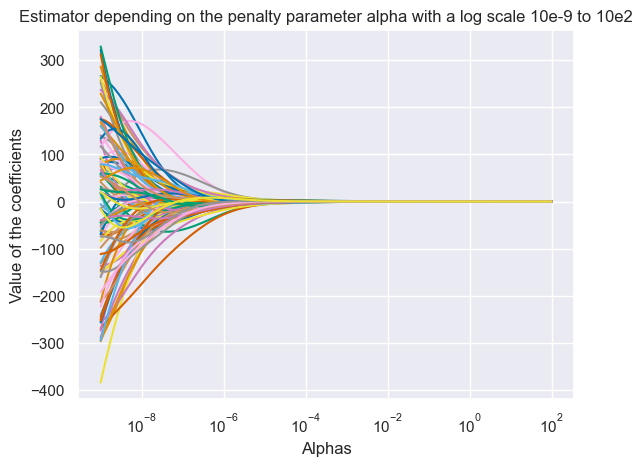

In [15]:
# Define our own ridge function
def ridge(X, y, a) :
    n = X.shape[1]
    estimator = inv(((X.T)@X + n*a*np.eye(n)))@(X.T)@y
    return estimator

# Define the list of the alphas
alphas = np.logspace(-9, 2, num=100, base=10)

# For each alpha, compute the ridge and store it in a list
estimatorlist = []
for i in alphas :
    estimatorlist.append(ridge(X_train, y_train, i))


list_values = []
for i in range(len(estimatorlist[0])) :
    val = []
    for j in range(len(estimatorlist)) :
        val.append(estimatorlist[j][i])
    list_values.append(val)


plt.figure()
plt.xscale('log')
plt.xlabel("Alphas")
plt.ylabel("Value of the coefficients")

# Plot the results
for i in range(len(list_values)-1) :
    plt.plot(alphas, list_values[i])
plt.title("Estimator depending on the penalty parameter alpha with a log scale 10e-9 to 10e2")
    

#### b) Plot how MSE of both the train and test sets change with α. Signal the minimum with a point.

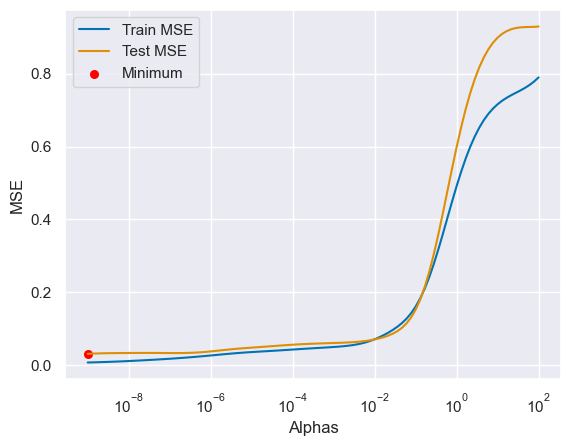

In [16]:
# Define empty lists that we'll fill
train_mse = []
test_mse = []

# Iterate over alphas and compute for every one of them both train and test's MSE
for i in alphas :
    estimator = ridge(X_train, y_train, i)
    y_pred_train = np.dot(X_train, estimator)
    y_pred_test = np.dot(X_test, estimator)
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    train_mse.append(mse_train)
    test_mse.append(mse_test)

# Compute the min
min_y = np.min(test_mse)
min_x = alphas[np.argmin(test_mse)]

# Plot the results
plt.xlabel("Alphas")
plt.ylabel("MSE")
plt.xscale('log')
plt.plot(alphas, train_mse, label ="Train MSE")
plt.plot(alphas, test_mse, label="Test MSE")
plt.scatter(min_x, min_y, color="red", marker="o", s=30, label="Minimum")
plt.legend()
plt.show()

#### c) Store the r2 coefficient for the best alpha

Given the previous graphic, the MSE is non decreasing. Therefore, the best alpha is $10^{-9}$.

In [17]:
# Compute the R2 coefficient for the best alpha
a = 10**(-9)
rdg = ridge(X_train, y_train, a)
y_pred_test = np.dot(X_test, rdg)
r2 = r2coeff_np(y_test, y_pred_test)
print("The R2 coefficient is : {}".format(r2))
print(' ')

df_coef['Ridge'] = r2

print(df_coef.head())

The R2 coefficient is : 0.9661012525400319
 
        OLS  OLS with variable selection     Ridge
0  0.960055                     0.960101  0.966101


## Cross-validation, Lasso and elastic net

### Question 6

#### a) Elaborate on why these warning arise and on the solution.

The tol parameter (which stands for tolerance) controls the stopping criterion for the algorithm. If it is set too high, the algorithm may not converge to the optimal solution. Therefore, it may continue running until max_iter is reached, raising a warning.\
To avoid this, you can either decrease the tolerance or increase the maximum number of iterations.\
Decreasing tol will make the algorithm more strict in determining when to stop the optimization process, thus reducing the chances of the algorithm not converging. On the other hand, increasing the maximum number of iterations allows the algorithm more time to find the optimal solution, which can also help to reduce the chances of the algorithm not converging. However, I could run for too long even though it is not necessary.

#### b) Plot the number of coefficients that are different from 0 for each value of α

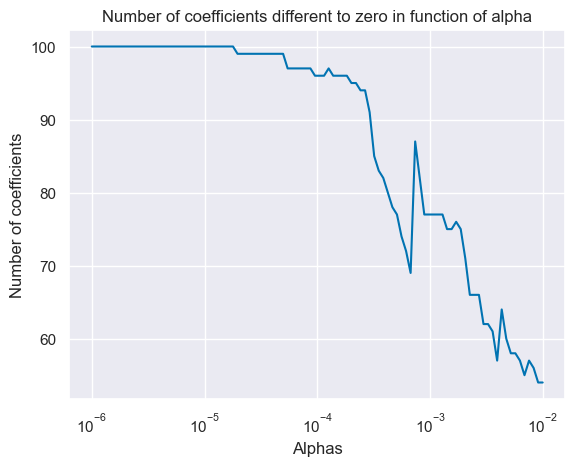

In [18]:
# Define the list of alphas
alphas2 = np.logspace(-6, -2, num=100, base=10)

# Define and fill the list of the lasso
lasso_list = []
nb_coef_not_0 = []
# Iterate over alphas2 to count the number of coefficients equal to zero
for a in alphas2 :
    incr = 0
    las = Lasso(a, tol=0.05, max_iter=20000)
    las.fit(X_train, y_train)
    for i in las.coef_ :
        if i==0 :
            incr+=1
    nb_coef_not_0.append(len(las.coef_)-incr)
    lasso_list.append(las)

# Plot the results
plt.plot(alphas2, nb_coef_not_0)
plt.title("Number of coefficients different to zero in function of alpha")
plt.xlabel("Alphas")
plt.ylabel("Number of coefficients")
plt.xscale('log')
plt.show()
    

#### c) Plot how MSE of both the train and test sets change with α. Signal the minimum with a point.

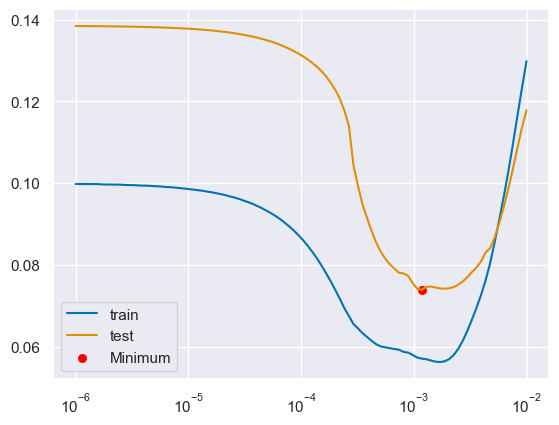

In [19]:
# Here, we basically do the same as in question 5)b)
train_mse2 = []
test_mse2 = []

for las in lasso_list :
    y_pred_train = las.predict(X_train)
    y_pred_test = las.predict(X_test)
    train_mse2.append(mean_squared_error(y_train, y_pred_train))
    test_mse2.append(mean_squared_error(y_test, y_pred_test))

# Compute the min
min_y = np.min(test_mse2)
min_x = alphas2[np.argmin(test_mse2)]

# Plot the results
plt.xscale('log')
plt.plot(alphas2, train_mse2, label = "train")
plt.plot(alphas2, test_mse2, label = "test")
plt.scatter(min_x, min_y, color="red", marker="o", s=30, label="Minimum")
plt.legend()

#### d) For the best performing value of α on the test set store the R2 results.

In [20]:
# Compute the R2 coefficient for the best alpha
lasso = Lasso(10**(-3), tol=0.05, max_iter=20000)
lasso.fit(X_test, y_test)
y_pred = lasso.predict(X_test)
r2_test_best = r2_score(y_test, y_pred)

print("The r2 coefficient obtained is : {} ".format(r2_test_best))

# Store the coefficient
df_coef['Lasso'] = r2_test_best
print(df_coef.head())

The r2 coefficient obtained is : 0.9401103051557163 
        OLS  OLS with variable selection     Ridge    Lasso
0  0.960055                     0.960101  0.966101  0.94011


### Question 7

In [21]:
# Ignore Lasso warnings
warnings.filterwarnings('ignore', module='sklearn.linear_model')

In [22]:
# Define a cross validation function
def custom_cross_val_score(X, y, model, splits=5):
    kf = KFold(n_splits=splits, shuffle=True)
    scores = []
    for train_index, test_index in kf.split(X):
        X_train_cv, X_test_cv = X.loc[train_index], X.loc[test_index]
        y_train_cv, y_test_cv = y.loc[train_index], y.loc[test_index]
        model.fit(X_train_cv, y_train_cv)
        score = model.score(X_test_cv, y_test_cv)
        scores.append(score)
    return np.array(scores)

In [23]:
# Initialize the ElasticNet model
enet = ElasticNet(alpha=0.1, l1_ratio=0.5)

# Calculate the cross-validation scores
scores = custom_cross_val_score(X, y, enet)
print("List of R2 scores : {}".format(scores))
print(' ')

# Calculate the mean and standard deviation of the scores
mean_score = np.mean(scores)
std_score = np.std(scores)

print("Mean of the list : {}".format(mean_score))
    

List of R2 scores : [0.68733548 0.59319663 0.69610423 0.66986199 0.58789921]
 
Mean of the list : 0.6468795063673864


We obtain a very bad R2 coefficient, maybe it is a poor model for our problem.

In [24]:
# Since our previous implementation didn't work for the ridge (it doesn't have .fit or .predict methods), we are adapting it
def custom_cross_val_score_ridge(X, y, a, splits=5):
    kf = KFold(n_splits=splits, shuffle=True)
    scores = []
    y = y.to_numpy()
    for train_index, test_index in kf.split(X):
        X_train_cv, X_test_cv = X.loc[train_index], X.loc[test_index]
        y_train_cv = y[train_index]
        y_test_cv = y[test_index]
        rdg = ridge(X_train_cv, y_train_cv, a)
        y_pred_test = np.dot(X_test_cv, rdg)
        r2 = r2coeff_np(y_test_cv, y_pred_test)
        scores.append(r2)
    return np.array(scores)


C:\Users\titou\AppData\Local\Temp\ipykernel_35128\3302782703.py:7: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(X_train_cv, y_train_cv)
C:\Users\titou\AppData\Local\Temp\ipykernel_35128\3302782703.py:7: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(X_train_cv, y_train_cv)
C:\Users\titou\AppData\Local\Temp\ipykernel_35128\3302782703.py:7: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(X_train_cv, y_train_cv)
C:\Users\titou\AppData\Local\Temp\ipykernel_35128\3302782703.py:7: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(X_train_cv, y_train_cv)
C:\Users\titou\AppData\Local\Temp\ipykernel_35128\3302782703.py:7: UserWarning: With alpha=0, this algorithm

Text(0.5, 1.0, "Ridge's average r2 depending on alpha")

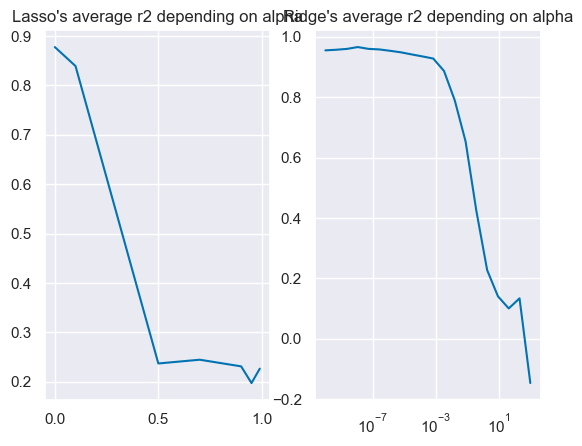

In [25]:
# Define the list of alphas given
alpha_las = [0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99]
alphas_rdg = np.logspace(-10, 3, num=20, base=10)

# Iterate over those lists and compute the scores

las_mean = []
for a in alpha_las :
    las = Lasso(a, tol=0.05, max_iter=20000)
    scores_las = custom_cross_val_score(X, y, las)
    las_mean.append(np.mean(scores_las))
las_score = np.array(las_mean)

rdg_mean = []
for a in alphas_rdg :
    scores_rdg = custom_cross_val_score_ridge(X, y, a)
    rdg_mean.append(np.mean(scores_rdg))
rdg_score = np.array(rdg_mean)

# Plot the results

fig = plt.figure()

ax1 = plt.subplot(1, 2, 1)
ax1.plot(alpha_las, las_score)
ax1.set_title("Lasso's average r2 depending on alpha")

ax2 = plt.subplot(1, 2, 2)
ax2.plot(alphas_rdg, rdg_score)
ax2.set_xscale('log')
ax2.set_title("Ridge's average r2 depending on alpha")



We can see that the ridge and lasso work better for the smaller alpha

## Bootstrap

### Question 8

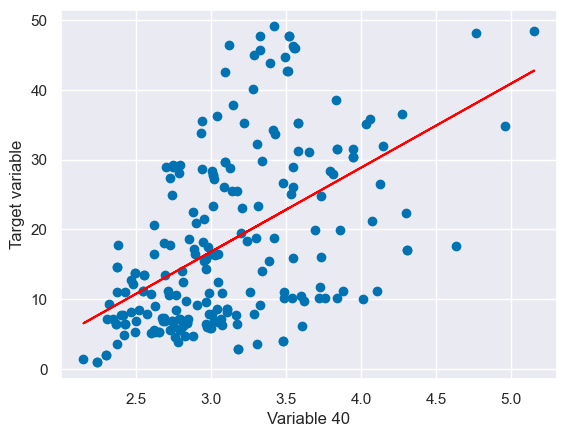

In [26]:
# Extract variable 40 from the original dataset X
X_40 = X.iloc[:, 39]
X_40 = X_40.to_numpy()

# Fit a linear regression model to the data
reg = LinearRegression().fit(X_40.reshape(-1, 1), y)

# Plot the data and the regression line
fig, ax = plt.subplots()
ax.scatter(X_40, y)
ax.plot(X_40, reg.predict(X_40.reshape(-1, 1)), color='red')
ax.set_xlabel('Variable 40')
ax.set_ylabel('Target variable')
plt.show()

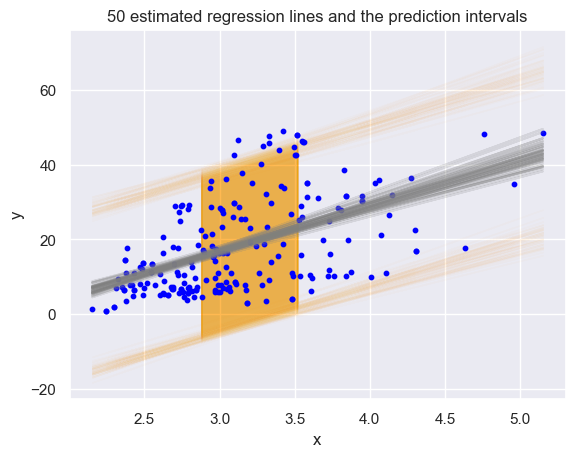

In [27]:
n_bootstraps = 50
bootstrapped_predictions = []

for i in range(n_bootstraps):
    sample_indices = np.random.choice(len(X_40), len(X_40), replace=True)
    x_sample = X_40[sample_indices]
    y_sample = y[sample_indices]
    coeffs = np.polyfit(x_sample, y_sample, 1)
    y_pred = np.polyval(coeffs, X_40)
    
    # plot the estimated regression line
    plt.plot(X_40, y_pred, color='gray', alpha=0.2)
    
    # calculate prediction interval
    y_pred_sample = np.polyval(coeffs, x_sample)
    sigma2 = np.sum((y_pred_sample - y_sample) ** 2) / (len(x_sample) - 2)
    sigma = np.sqrt(sigma2)
    t = stats.t.ppf(0.975, len(x_sample) - 2)
    y_err = t * sigma * np.sqrt(1 + 1 / len(X_40) + (X_40 - np.mean(x_sample)) ** 2 / np.sum((x_sample - np.mean(x_sample)) ** 2))
    bootstrapped_predictions.append(y_pred)
    plt.fill_between(X_40,y_pred - y_err, y_pred + y_err, alpha=0.02, color='orange')

# Plot the results
plt.scatter(X_40, y, s=10, color='blue')
plt.xlabel('x')
plt.ylabel('y')
plt.title("50 estimated regression lines and the prediction intervals")
plt.show()



### Question 9

#### a) Plot a heatmap of the covariance matrix.

Text(0.5, 1.0, "Heatmap of X's covariance matrix")

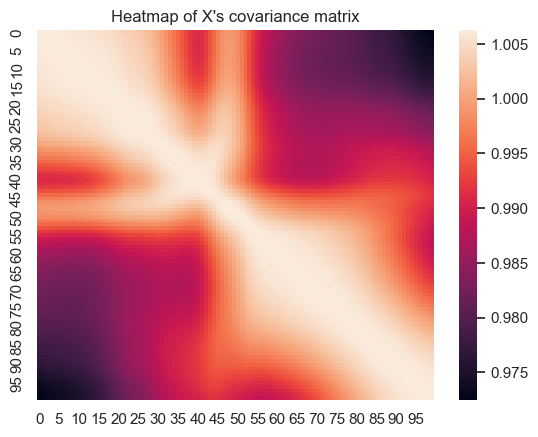

In [28]:
# Define the covariance matrix and plot the heatmap
X_cov = (X_train.T @ X_train)/len(X_train)
cov = np.cov(X_train, rowvar=False)
sns.heatmap(data=cov)
plt.title("Heatmap of X's covariance matrix")

#### b) Do a PCA

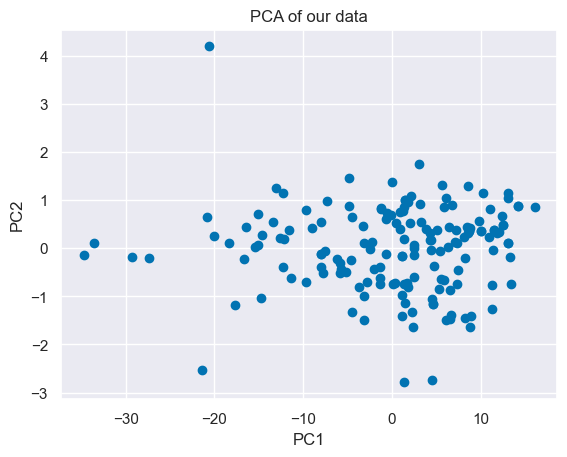

In [30]:
# Compute the SVD
U, s, V = np.linalg.svd(X_cov)

# Standardize X
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Compute the projection of the data onto the principal components
PC = np.dot(X_train, U[:, :2])

# Plot the data projected onto the first two principal components

plt.scatter(PC[:, 0], PC[:, 1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("PCA of our data")
plt.show()

#### c) Plot the amount of variance explained by the first k components

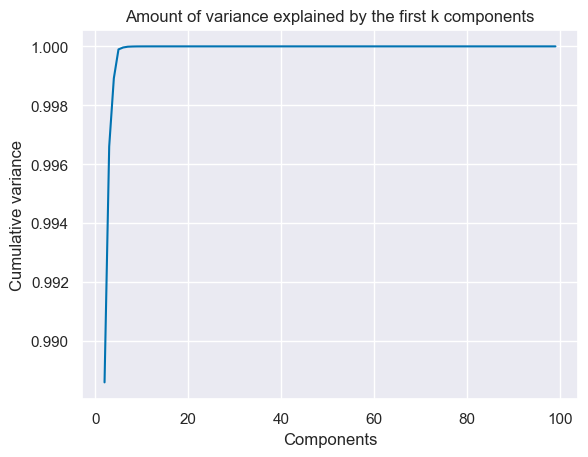

In [32]:
p = X_train.shape[1]
S = np.diag(s)
su = []
sum = 0
fi = 0
for k in range(0, p) :
    sum += S[k][k]

for i in range(2, p) :
    for j in range(0, i-1) :
        fi += S[j][j]/sum
    su.append(fi)
    fi = 0

# Plot the results
plt.plot([k for k in range(2,p)], su)
plt.xlabel("Components")
plt.ylabel("Cumulative variance")
plt.title("Amount of variance explained by the first k components")
plt.show()



As we can see, the first components are responsible for most of the cumulative variance.

#### d) Plot the projected data using as color the value of y and interpret the plot

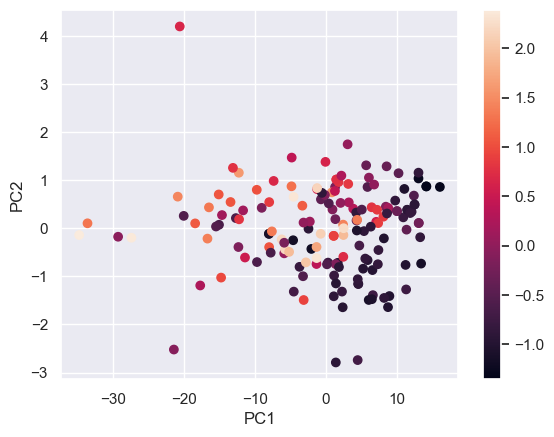

In [33]:
# Plot the data projected onto the first two principal components
plt.scatter(PC[:, 0], PC[:, 1], c=y_train)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("Projection of the data on y")
plt.colorbar()
plt.show()

#### e) Run OLS on the projected data using k components for k evenly spaced in 2..p. Store the best score in the dataFrame.

In [34]:
# define the range of k
k_range = range(2, p+1)

# initialize a list to store the scores
scores = []

# loop over the values of k
for k in k_range:
    # project the data onto the first k principal components
    PC = np.dot(X_std, U[:, :k])
    
    # split the data into training and testing sets
    X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(PC, y, test_size=0.2, random_state=42)
    
    # fit an OLS model to the training data
    model = LinearRegression()
    model.fit(X_train_2, y_train_2)
    
    # evaluate the model on the testing data and store the score
    score = model.score(X_test_2, y_test_2)
    scores.append(score)

# find the best score and corresponding value of k
best_score = max(scores)
best_k = k_range[scores.index(best_score)]
print(f"Best score: {best_score:.3f}")
print(f"Best k: {best_k}")
print(' ')
df_coef['PCA'] = best_score
print(df_coef.head())

Best score: 0.975
Best k: 67
 
        OLS  OLS with variable selection       SFS     Ridge    Lasso  \
0  0.960055                     0.960101  0.948842  0.966101  0.94011   

        PCA  
0  0.974571  


## Comparaison of the models

### Question 10

In [35]:
df_coef.head()

,OLS,OLS with variable selection,SFS,Ridge,Lasso,PCA
0,0.960055,0.960101,0.948842,0.966101,0.94011,0.974571


According to our results, it appears that the PCA is the model with most success since it has the highest R2 coefficient. Hence, it is the best model to use in this case.